In [1]:
# Required Libraries
import os
import json
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
import time
import math
import sklearn
import random
import pickle # For saving/loading scaler if used

# Configure Matplotlib for inline plotting in Jupyter
%matplotlib inline
sns.set(style="whitegrid")

print("TensorFlow Version:", tf.__version__)
print("Librosa Version:", librosa.__version__)
print("NumPy Version:", np.__version__)
print("Scikit-learn Version:", sklearn.__version__)

2025-04-23 09:56:25.931833: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-23 09:56:32.138206: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745384194.815507     462 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745384195.499217     462 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-23 09:56:43.893598: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

TensorFlow Version: 2.18.0
Librosa Version: 0.11.0
NumPy Version: 2.0.2
Scikit-learn Version: 1.6.1


In [4]:
# --- Configuration ---
# !!! ADJUST THESE PATHS !!!
DATASET_PATH = r"/mnt/e/LAB/Abdul_Rehman_Feb_New/code/AML/Data/genres_original" # Root folder of GTZAN dataset
JSON_PATH = r"/mnt/e/lab/Abdul_Rehman_Feb_New/AML/data_gzgan.json" # To save file list and labels mapping
FEATURES_PATH = "processed_features_mel_spec_notebook.npz" # To save extracted features
MODEL_SAVE_PATH = "music_genre_cnn_mel_spec_notebook.h5" # To save the trained model
LABEL_MAP_PATH = "genre_label_mapping_notebook.json" # To save genre name mapping
# SCALER_PATH = "scaler_notebook.pkl" # Path to save the scaler object (optional, if using StandardScaler)

# Audio Processing Parameters (Matching proposal focus: MFCCs/Mel-Spectrograms)
SAMPLE_RATE = 22050
DURATION = 30  # seconds (original duration)
SEGMENT_DURATION = 3 # seconds (segment length for CNN input)
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION
SAMPLES_PER_SEGMENT = int(SAMPLE_RATE * SEGMENT_DURATION) # Ensure integer
NUM_SEGMENTS_PER_TRACK = int(SAMPLES_PER_TRACK / SAMPLES_PER_SEGMENT) # Ensure integer

# Feature Extraction Parameters (Focusing on Mel-Spectrograms as per common CNN practice)
N_MELS = 128 # Number of Mel bands
N_FFT = 2048 # Window size for FFT
HOP_LENGTH = 512 # Samples between successive frames

# Data Split Parameters
TEST_SIZE = 0.15 # 15% for final testing
VALIDATION_SIZE = 0.15 # 15% for validation during training

# Training Parameters (Example - Step 5 discusses tuning)
EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 0.0001

# --- Data Loading Function ---
def load_data_paths_and_labels(dataset_path):
    """Scans the dataset directory and returns lists of file paths and labels."""
    if not os.path.exists(dataset_path):
        raise ValueError(f"Dataset path not found: {dataset_path}")

    all_files = []
    all_labels = []
    genre_mapping = {}
    genres = [g for g in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, g))]
    genres.sort() # Ensure consistent order

    for i, genre in enumerate(genres):
        genre_mapping[i] = genre
        genre_path = os.path.join(dataset_path, genre)
        for filename in os.listdir(genre_path):
            if filename.lower().endswith('.wav'):
                file_path = os.path.join(genre_path, filename)
                all_files.append(file_path)
                all_labels.append(i) # Use integer index as label

    print(f"Found {len(all_files)} audio files across {len(genres)} genres.")
    if len(all_files) == 0:
        raise ValueError(f"No .wav files found in {dataset_path} or its subdirectories.")

    return all_files, all_labels, genre_mapping

# --- Load Initial Data ---
try:
    all_files, all_labels_int, genre_mapping = load_data_paths_and_labels(DATASET_PATH)
    # Save the mapping for later use
    with open(LABEL_MAP_PATH, 'w') as f:
        json.dump(genre_mapping, f, indent=4)
    print("Genre Mapping:", genre_mapping)
    print(f"Data loading successful. Number of files: {len(all_files)}, Number of labels: {len(all_labels_int)}")
except ValueError as e:
    print(f"Error during data loading: {e}")
    # Stop execution if data isn't loaded
    raise SystemExit("Stopping execution due to data loading error.")

# Create a Pandas DataFrame for easier handling (optional but good for EDA)
data_df = pd.DataFrame({
    'file_path': all_files,
    'label_int': all_labels_int
})
# Map integer labels to genre names
data_df['genre'] = data_df['label_int'].map(genre_mapping)
print("\nSample of the data:")
print(data_df.head())

Found 1000 audio files across 10 genres.
Genre Mapping: {0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
Data loading successful. Number of files: 1000, Number of labels: 1000

Sample of the data:
                                           file_path  label_int  genre
0  /mnt/e/LAB/Abdul_Rehman_Feb_New/code/AML/Data/...          0  blues
1  /mnt/e/LAB/Abdul_Rehman_Feb_New/code/AML/Data/...          0  blues
2  /mnt/e/LAB/Abdul_Rehman_Feb_New/code/AML/Data/...          0  blues
3  /mnt/e/LAB/Abdul_Rehman_Feb_New/code/AML/Data/...          0  blues
4  /mnt/e/LAB/Abdul_Rehman_Feb_New/code/AML/Data/...          0  blues


/tmp/ipykernel_462/3663504125.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_df, y='genre', order=data_df['genre'].value_counts().index, palette='viridis')


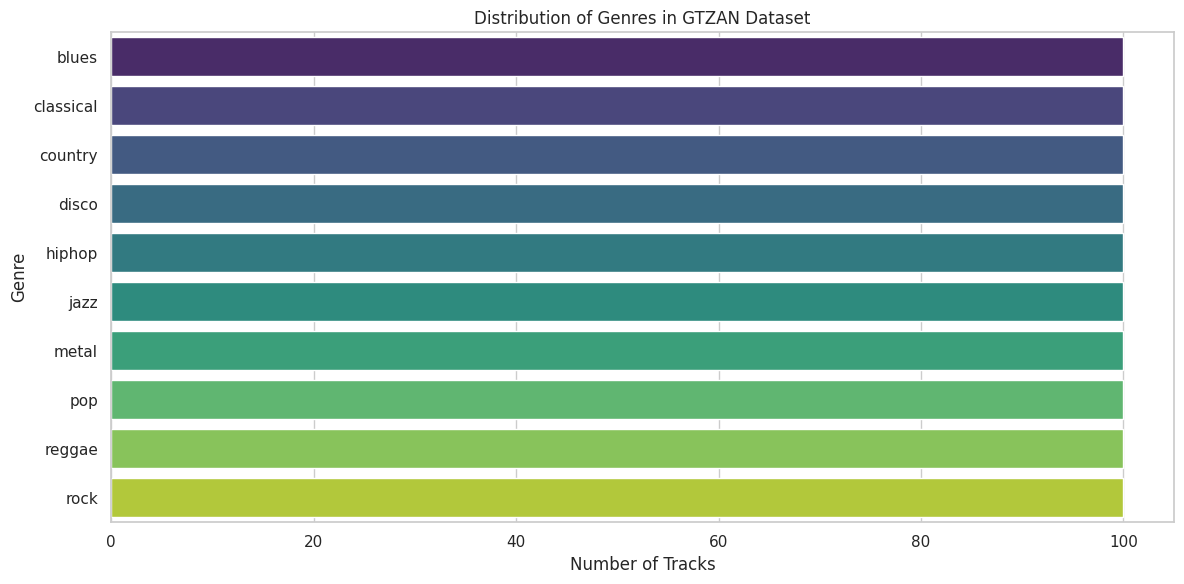


Genre Counts:
genre
blues        100
classical    100
country      100
disco        100
hiphop       100
jazz         100
metal        100
pop          100
reggae       100
rock         100
Name: count, dtype: int64


In [5]:
# --- Genre Distribution Visualization ---
plt.figure(figsize=(12, 6))
sns.countplot(data=data_df, y='genre', order=data_df['genre'].value_counts().index, palette='viridis')
plt.title('Distribution of Genres in GTZAN Dataset')
plt.xlabel('Number of Tracks')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

print("\nGenre Counts:")
print(data_df['genre'].value_counts())
# GTZAN is known to be balanced (100 tracks per genre), this confirms it.


Visualizing Waveforms for Sample Tracks:


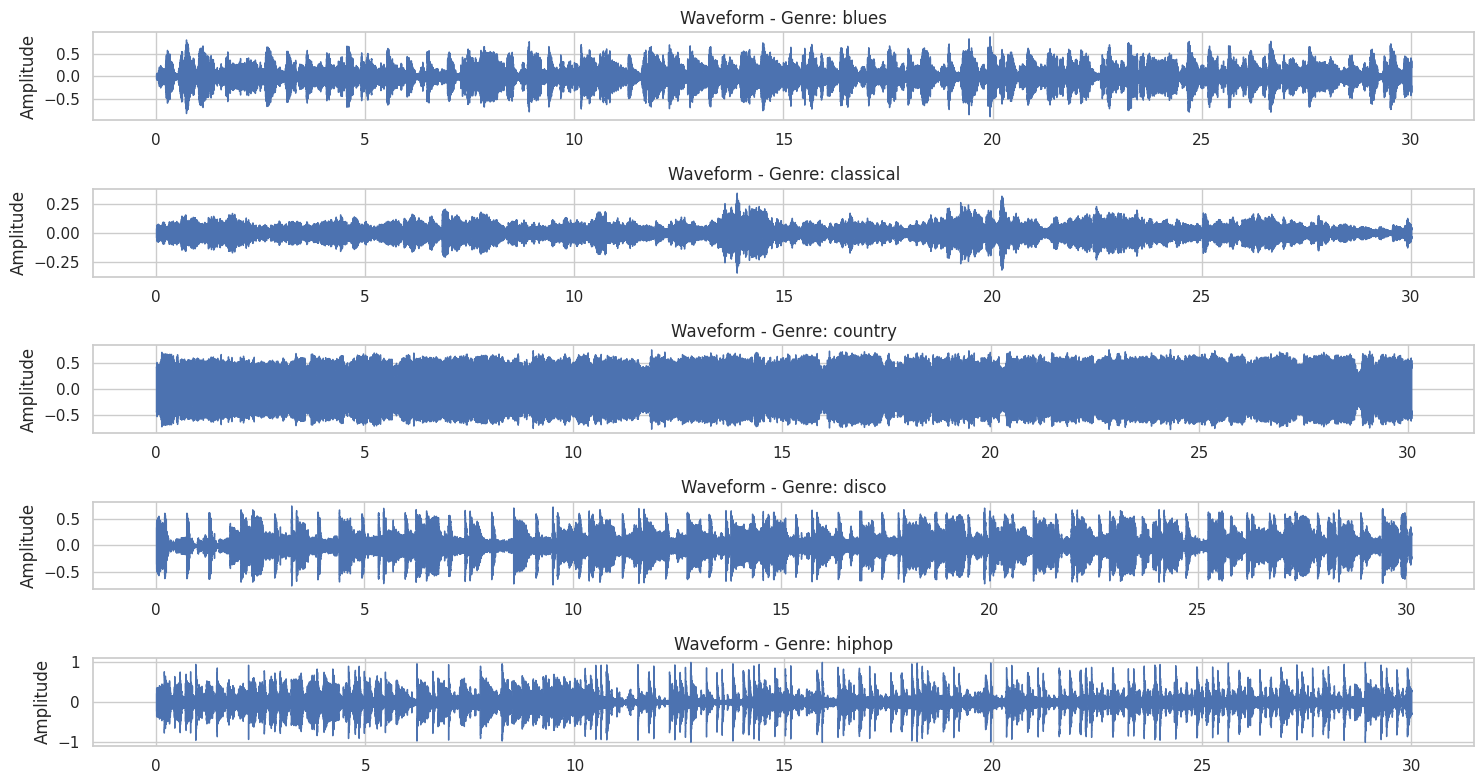

In [6]:
# --- Waveform Visualization ---
print("\nVisualizing Waveforms for Sample Tracks:")
num_genres_to_show = 5
genres_to_show = list(genre_mapping.values())[:num_genres_to_show] # Show first 5 genres

plt.figure(figsize=(15, 8))
for i, genre_name in enumerate(genres_to_show):
    # Find a sample file for this genre
    sample_file = data_df[data_df['genre'] == genre_name]['file_path'].iloc[0]
    try:
        y, sr = librosa.load(sample_file, sr=SAMPLE_RATE)
        plt.subplot(num_genres_to_show, 1, i + 1)
        librosa.display.waveshow(y, sr=sr)
        plt.title(f'Waveform - Genre: {genre_name}')
        plt.xlabel(None) # Remove x-label for intermediate plots
        plt.ylabel('Amplitude')
    except Exception as e:
        print(f"Could not load or plot {sample_file}: {e}")

plt.tight_layout()
plt.show()


Visualizing n Mel-Spectrograms for Sample Tracks:


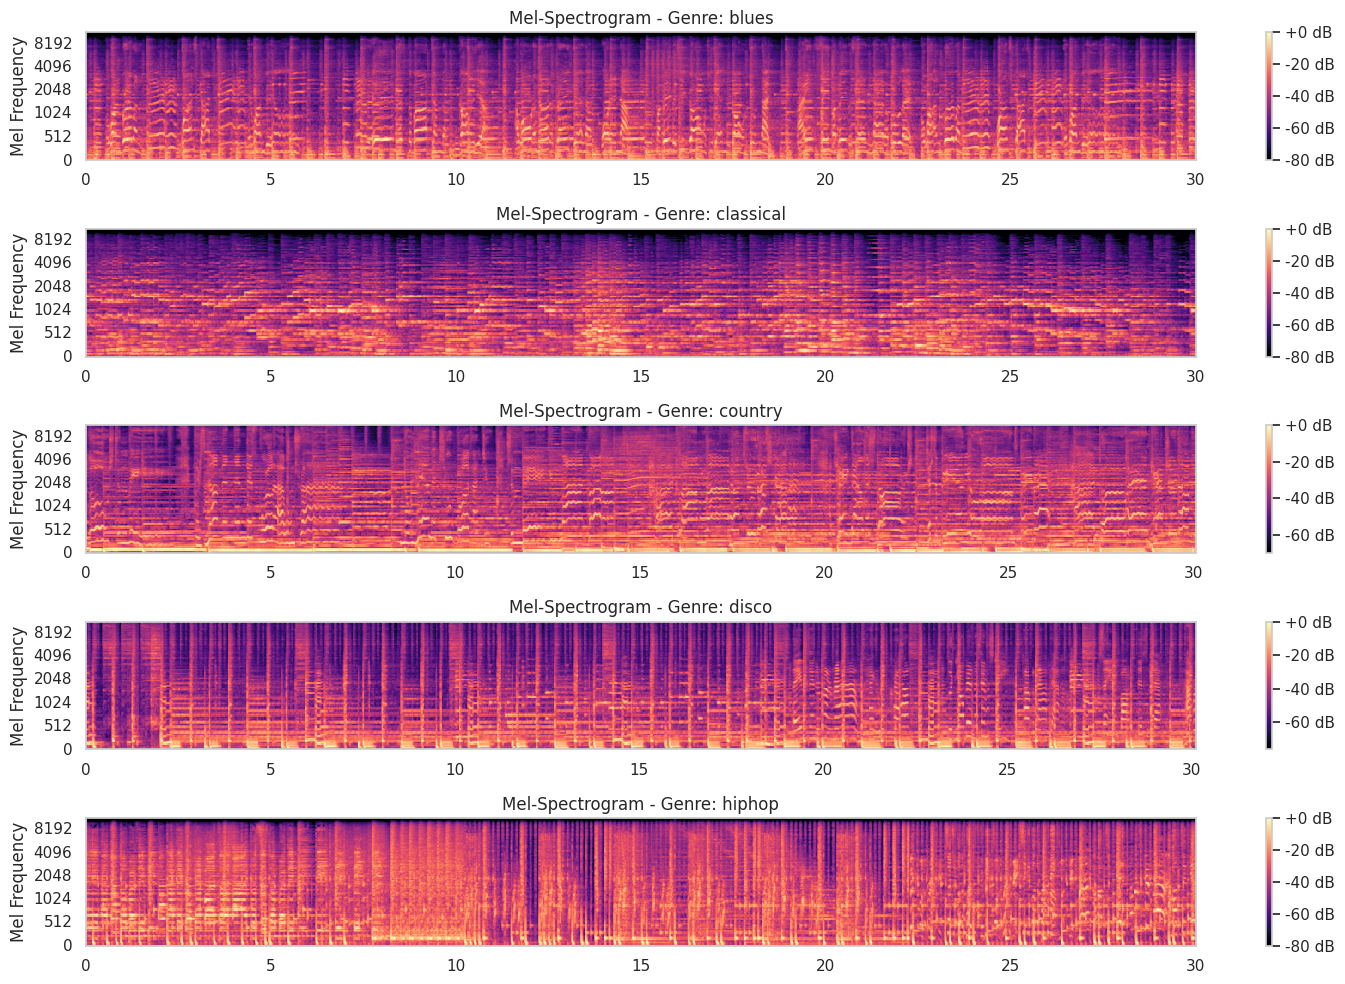

In [8]:
# --- Mel-Spectrogram Visualization ---
print("\nVisualizing n Mel-Spectrograms for Sample Tracks:")

plt.figure(figsize=(15, 10)) # Adjust size for better layout
for i, genre_name in enumerate(genres_to_show):
    sample_file = data_df[data_df['genre'] == genre_name]['file_path'].iloc[0]
    try:
        y, sr = librosa.load(sample_file, sr=SAMPLE_RATE)
        # Calculate Mel-Spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)
        # Convert to dB (log scale)
        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

        plt.subplot(num_genres_to_show, 1, i + 1)
        librosa.display.specshow(log_mel_spec, sr=sr, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Mel-Spectrogram - Genre: {genre_name}')
        plt.xlabel(None)
        plt.ylabel('Mel Frequency')
    except Exception as e:
        print(f"Could not process or plot spectrogram for {sample_file}: {e}")

plt.tight_layout()
plt.show()

Loading features from processed_features_mel_spec_notebook.npz...
Error loading features from processed_features_mel_spec_notebook.npz: No data left in file
Corrupted file detected. Deleting and re-extracting features...
Starting feature extraction... Expected samples/segment: 66150, Expected Mel vectors/segment: 130
  Processing file 50/1000: blues.00049.wav
  Processing file 100/1000: blues.00099.wav
  Processing file 150/1000: classical.00049.wav
  Processing file 200/1000: classical.00099.wav
  Processing file 250/1000: country.00049.wav
  Processing file 300/1000: country.00099.wav
  Processing file 350/1000: disco.00049.wav
  Processing file 400/1000: disco.00099.wav
  Processing file 450/1000: hiphop.00049.wav
  Processing file 500/1000: hiphop.00099.wav
  Processing file 550/1000: jazz.00049.wav


/tmp/ipykernel_462/3457821434.py:16: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, current_sr = librosa.load(file_path, sr=sr)
/mnt/e/lab/Abdul_Rehman_Feb_New/conda/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


  Error processing jazz.00054.wav: 
  Processing file 600/1000: jazz.00099.wav
  Processing file 650/1000: metal.00049.wav
  Processing file 700/1000: metal.00099.wav
  Processing file 750/1000: pop.00049.wav
  Processing file 800/1000: pop.00099.wav
  Processing file 850/1000: reggae.00049.wav
  Processing file 900/1000: reggae.00099.wav
  Processing file 950/1000: rock.00049.wav
  Processing file 1000/1000: rock.00099.wav

Feature extraction finished in 129.40 seconds.
Total segments processed: 9981
Features and labels re-saved to processed_features_mel_spec_notebook.npz


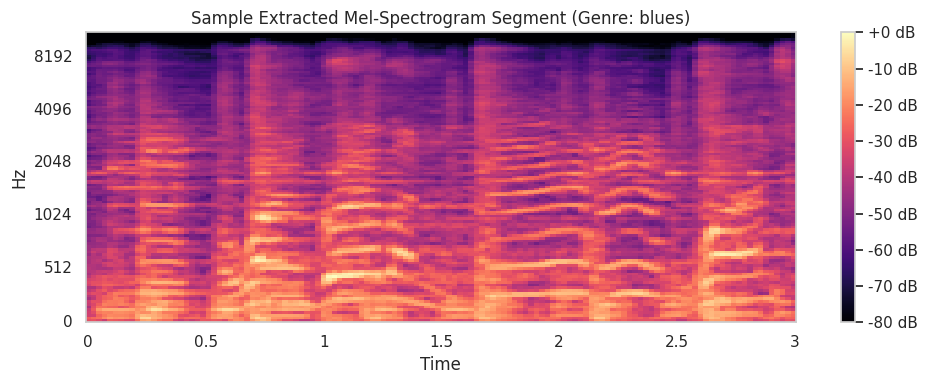

In [11]:
# --- Feature Extraction Function ---
def extract_features(file_paths, labels_int, sr, n_mels, n_fft, hop_length, segment_duration, num_segments_per_track):
    """Extracts Mel-Spectrogram features from audio files and segments them."""
    start_time = time.time()
    processed_features = []
    processed_labels = []

    samples_per_segment = int(sr * segment_duration)
    num_expected_vectors_per_segment = math.ceil(samples_per_segment / hop_length) # Expected time steps
    print(f"Starting feature extraction... Expected samples/segment: {samples_per_segment}, Expected Mel vectors/segment: {num_expected_vectors_per_segment}")

    for i, file_path in enumerate(file_paths):
        if (i + 1) % 50 == 0: # Print progress
             print(f"  Processing file {i+1}/{len(file_paths)}: {os.path.basename(file_path)}")
        try:
            signal, current_sr = librosa.load(file_path, sr=sr)

            # Ensure track is long enough for at least one full segment (robustness)
            if len(signal) < samples_per_segment:
                 print(f"  Warning: Skipping {os.path.basename(file_path)} (shorter than one segment: {len(signal)} < {samples_per_segment})")
                 continue

            # Process segments
            for s in range(num_segments_per_track):
                start_sample = s * samples_per_segment
                finish_sample = start_sample + samples_per_segment

                # Check boundary conditions
                if finish_sample > len(signal):
                     # print(f"    Segment {s+1} exceeds track length for {os.path.basename(file_path)}. Skipping remaining.")
                     break # Stop processing segments for this file if out of bounds

                audio_segment = signal[start_sample:finish_sample]

                # Extract Mel-Spectrogram
                mel_spec = librosa.feature.melspectrogram(y=audio_segment, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
                log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

                # Ensure fixed shape
                if log_mel_spec.shape == (n_mels, num_expected_vectors_per_segment):
                    processed_features.append(log_mel_spec)
                    processed_labels.append(labels_int[i]) # Assign original track's label to the segment
                else:
                    # Handle potential minor shape mismatches due to rounding/edge effects
                    # Common fix: Pad or truncate along the time axis (axis=1)
                    if log_mel_spec.shape[1] > num_expected_vectors_per_segment:
                        log_mel_spec = log_mel_spec[:, :num_expected_vectors_per_segment]
                    elif log_mel_spec.shape[1] < num_expected_vectors_per_segment:
                        pad_width = num_expected_vectors_per_segment - log_mel_spec.shape[1]
                        log_mel_spec = np.pad(log_mel_spec, pad_width=((0, 0), (0, pad_width)), mode='constant')
                    
                    if log_mel_spec.shape == (n_mels, num_expected_vectors_per_segment):
                        processed_features.append(log_mel_spec)
                        processed_labels.append(labels_int[i])
                    # else: # Still mismatched after padding/truncation? Skip.
                    #     print(f"  Warning: Segment {s+1} in {os.path.basename(file_path)} has incorrect shape {log_mel_spec.shape} even after fix. Skipping.")

        except Exception as e:
            print(f"  Error processing {os.path.basename(file_path)}: {e}")

    end_time = time.time()
    print(f"\nFeature extraction finished in {end_time - start_time:.2f} seconds.")
    print(f"Total segments processed: {len(processed_features)}")

    if not processed_features:
        raise ValueError("No features were extracted.")

    return np.array(processed_features), np.array(processed_labels)


# --- Execute Feature Extraction (if file doesn't exist) ---
if not os.path.exists(FEATURES_PATH):
    print(f"Feature file '{FEATURES_PATH}' not found. Extracting features...")
    try:
        X_features, y_labels = extract_features(
            data_df['file_path'].tolist(),
            data_df['label_int'].tolist(),
            SAMPLE_RATE, N_MELS, N_FFT, HOP_LENGTH, SEGMENT_DURATION, NUM_SEGMENTS_PER_TRACK
        )
        # Save features and labels
        np.savez(FEATURES_PATH, features=X_features, labels=y_labels)
        print(f"Features and labels saved to {FEATURES_PATH}")
    except ValueError as e:
        print(f"Error during feature extraction: {e}")
        raise SystemExit("Stopping execution due to feature extraction error.")
    except Exception as e:
        print(f"An unexpected error occurred during feature extraction: {e}")
        raise SystemExit("Stopping execution due to unexpected feature extraction error.")

else:
    print(f"Loading features from {FEATURES_PATH}...")
    try:
        data = np.load(FEATURES_PATH)
        X_features = data['features']
        y_labels = data['labels']
        print(f"Features loaded successfully. Shape: {X_features.shape}, Labels shape: {y_labels.shape}")
        if X_features.size == 0 or y_labels.size == 0:
             raise ValueError("Loaded features or labels are empty.")
    except Exception as e:
        print(f"Error loading features from {FEATURES_PATH}: {e}")
        print("Corrupted file detected. Deleting and re-extracting features...")
        os.remove(FEATURES_PATH)  # Delete the corrupted file
        X_features, y_labels = extract_features(
            data_df['file_path'].tolist(),
            data_df['label_int'].tolist(),
            SAMPLE_RATE, N_MELS, N_FFT, HOP_LENGTH, SEGMENT_DURATION, NUM_SEGMENTS_PER_TRACK
        )
        np.savez(FEATURES_PATH, features=X_features, labels=y_labels)
        print(f"Features and labels re-saved to {FEATURES_PATH}")


# --- Visualize a Sample Extracted Feature ---
if X_features.size > 0:
    plt.figure(figsize=(10, 4))
    sample_feature_index = 0 # Visualize the first extracted segment
    librosa.display.specshow(X_features[sample_feature_index], sr=SAMPLE_RATE, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    original_label_int = y_labels[sample_feature_index]
    original_genre = genre_mapping.get(original_label_int, "Unknown")
    plt.title(f'Sample Extracted Mel-Spectrogram Segment (Genre: {original_genre})')
    plt.tight_layout()
    plt.show()
else:
    print("Skipping feature visualization as no features were loaded/extracted.")

In [12]:
# --- Data Augmentation Functions (Demonstration) ---
def add_noise(audio_segment, noise_factor=0.005):
    noise = np.random.randn(len(audio_segment))
    augmented_audio = audio_segment + noise_factor * noise
    # Cast back to same data type and clip range
    augmented_audio = augmented_audio.astype(type(audio_segment[0]))
    return augmented_audio

def time_stretch(audio_segment, rate=1.0): # rate > 1 speeds up, < 1 slows down
    if rate == 1.0: return audio_segment
    return librosa.effects.time_stretch(y=audio_segment, rate=rate)

def pitch_shift(audio_segment, sr, n_steps=0): # n_steps = number of semitones
    if n_steps == 0 : return audio_segment
    return librosa.effects.pitch_shift(y=audio_segment, sr=sr, n_steps=n_steps)

# Example: How you *might* apply augmentation conceptually before feature extraction
# (Not run here, integrated into extract_features or a data generator usually)
# if is_training_data and random.random() < 0.5: # Apply randomly
#     aug_type = random.choice(['noise', 'pitch', 'stretch'])
#     if aug_type == 'noise':
#         audio_segment = add_noise(audio_segment, noise_factor=0.005)
#     # ... other augmentations ...
#     # Then extract features from the augmented_audio_segment


Splitting data into Training, Validation, and Test sets...
Training set shape: (6986, 128, 130), Labels: (6986,)
Validation set shape: (1497, 128, 130), Labels: (1497,)
Test set shape: (1498, 128, 130), Labels: (1498,)
Input shape for CNN: (128, 130, 1)
Labels successfully one-hot encoded. Example shape: (6986, 10)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 130, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 128, 130, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128, 130, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 130, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128, 130, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 65, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64, 65, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 65, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64, 65, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 65, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 64, 65, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 33, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32, 33, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 33, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 32, 33, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 33, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 33, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 17, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 16, 17, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,244,906 (4.75 MB)

 Trainable params: 1,242,474 (4.74 MB)

 Non-trainable params: 2,432 (9.50 KB)


Starting model training...
Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2961 - loss: 2.2307
Epoch 1: val_accuracy improved from -inf to 0.27589, saving model to music_genre_cnn_mel_spec_notebook.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 17s 52ms/step - accuracy: 0.2964 - loss: 2.2296 - val_accuracy: 0.2759 - val_loss: 2.8038
Epoch 2/100
217/219 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4487 - loss: 1.6575
Epoch 2: val_accuracy improved from 0.27589 to 0.36607, saving model to music_genre_cnn_mel_spec_notebook.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.4488 - loss: 1.6569 - val_accuracy: 0.3661 - val_loss: 2.3426
Epoch 3/100
217/219 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5167 - loss: 1.4460
Epoch 3: val_accuracy improved from 0.36607 to 0.42351, saving model to music_genre_cnn_mel_spec_notebook.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.5169 - loss: 1.4456 - val_accuracy: 0.4235 - val_loss: 2.6104
Epoch 4/100
217/219 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5618 - loss: 1.2909
Epoch 4: val_accuracy improved from 0.42351 to 0.43487, saving model to music_genre_cnn_mel_spec_notebook.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.5619 - loss: 1.2908 - val_accuracy: 0.4349 - val_loss: 2.3245
Epoch 5/100
217/219 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5943 - loss: 1.2300
Epoch 5: val_accuracy improved from 0.43487 to 0.44756, saving model to music_genre_cnn_mel_spec_notebook.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.5944 - loss: 1.2297 - val_accuracy: 0.4476 - val_loss: 2.4079
Epoch 6/100
217/219 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6386 - loss: 1.1140
Epoch 6: val_accuracy did not improve from 0.44756
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.6387 - loss: 1.1134 - val_accuracy: 0.3888 - val_loss: 3.1200
Epoch 7/100
217/219 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6546 - loss: 1.0000
Epoch 7: val_accuracy improved from 0.44756 to 0.48096, saving model to music_genre_cnn_mel_spec_notebook.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.6547 - loss: 0.9999 - val_accuracy: 0.4810 - val_loss: 2.5681
Epoch 8/100
217/219 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6803 - loss: 0.9526
Epoch 8: val_accuracy did not improve from 0.48096
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.6803 - loss: 0.9526 - val_accuracy: 0.4302 - val_loss: 3.2433
Epoch 9/100
217/219 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6925 - loss: 0.8962
Epoch 9: val_accuracy improved from 0.48096 to 0.51303, saving model to music_genre_cnn_mel_spec_notebook.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.6926 - loss: 0.8961 - val_accuracy: 0.5130 - val_loss: 1.9561
Epoch 10/100
217/219 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7303 - loss: 0.8114
Epoch 10: val_accuracy improved from 0.51303 to 0.57582, saving model to music_genre_cnn_mel_spec_notebook.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.7303 - loss: 0.8115 - val_accuracy: 0.5758 - val_loss: 1.5702
Epoch 11/100
217/219 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7266 - loss: 0.7999
Epoch 11: val_accuracy improved from 0.57582 to 0.63527, saving model to music_genre_cnn_mel_spec_notebook.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.7268 - loss: 0.7995 - val_accuracy: 0.6353 - val_loss: 1.3660
Epoch 12/100
217/219 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7394 - loss: 0.7478
Epoch 12: val_accuracy did not improve from 0.63527
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7396 - loss: 0.7477 - val_accuracy: 0.5939 - val_loss: 1.7358
Epoch 13/100
217/219 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7597 - loss: 0.7091
Epoch 13: val_accuracy did not improve from 0.63527
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7597 - loss: 0.7092 - val_accuracy: 0.5792 - val_loss: 1.7561
Epoch 14/100
217/219 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7599 - loss: 0.7068
Epoch 14: val_accuracy did not improve from 0.63527
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7601 - loss: 0.7062 - val_accuracy: 0.6226 - val_loss: 1.4272
Epoch 15/100
217/219 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7869 - loss: 0.6163
Epoch 15: val_ac

219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.7869 - loss: 0.6164 - val_accuracy: 0.6593 - val_loss: 1.3755
Epoch 16/100
217/219 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8110 - loss: 0.5748
Epoch 16: val_accuracy did not improve from 0.65932
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8110 - loss: 0.5747 - val_accuracy: 0.6025 - val_loss: 1.8595
Epoch 17/100
217/219 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8154 - loss: 0.5738
Epoch 17: val_accuracy did not improve from 0.65932
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8155 - loss: 0.5736 - val_accuracy: 0.6593 - val_loss: 1.2306
Epoch 18/100
217/219 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8175 - loss: 0.5378
Epoch 18: val_accuracy improved from 0.65932 to 0.67001, saving model to music_genre_cnn_mel_spec_notebook.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.8176 - loss: 0.5376 - val_accuracy: 0.6700 - val_loss: 1.3499
Epoch 19/100
217/219 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8319 - loss: 0.5023
Epoch 19: val_accuracy improved from 0.67001 to 0.69272, saving model to music_genre_cnn_mel_spec_notebook.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.8319 - loss: 0.5021 - val_accuracy: 0.6927 - val_loss: 1.1044
Epoch 20/100
217/219 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8314 - loss: 0.4940
Epoch 20: val_accuracy did not improve from 0.69272
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8314 - loss: 0.4939 - val_accuracy: 0.5017 - val_loss: 2.2147
Epoch 21/100
217/219 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8478 - loss: 0.4642
Epoch 21: val_accuracy did not improve from 0.69272
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.8478 - loss: 0.4641 - val_accuracy: 0.6880 - val_loss: 1.2451
Epoch 22/100
217/219 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8531 - loss: 0.4383
Epoch 22: val_accuracy did not improve from 0.69272
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.8531 - loss: 0.4383 - val_accuracy: 0.6747 - val_loss: 1.2482
Epoch 23/100
217/219 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8678 - loss: 0.4059
Epoch 23: val_ac

219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.8677 - loss: 0.4061 - val_accuracy: 0.8424 - val_loss: 0.5226
Epoch 24/100
217/219 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8621 - loss: 0.4174
Epoch 24: val_accuracy did not improve from 0.84235
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8622 - loss: 0.4173 - val_accuracy: 0.7014 - val_loss: 1.1732
Epoch 25/100
217/219 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8834 - loss: 0.3675
Epoch 25: val_accuracy did not improve from 0.84235
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.8833 - loss: 0.3676 - val_accuracy: 0.6473 - val_loss: 1.3233
Epoch 26/100
217/219 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8729 - loss: 0.3829
Epoch 26: val_accuracy did not improve from 0.84235
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8730 - loss: 0.3827 - val_accuracy: 0.5892 - val_loss: 1.8451
Epoch 27/100
217/219 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8826 - loss: 0.3518
Epoch 27: val_ac

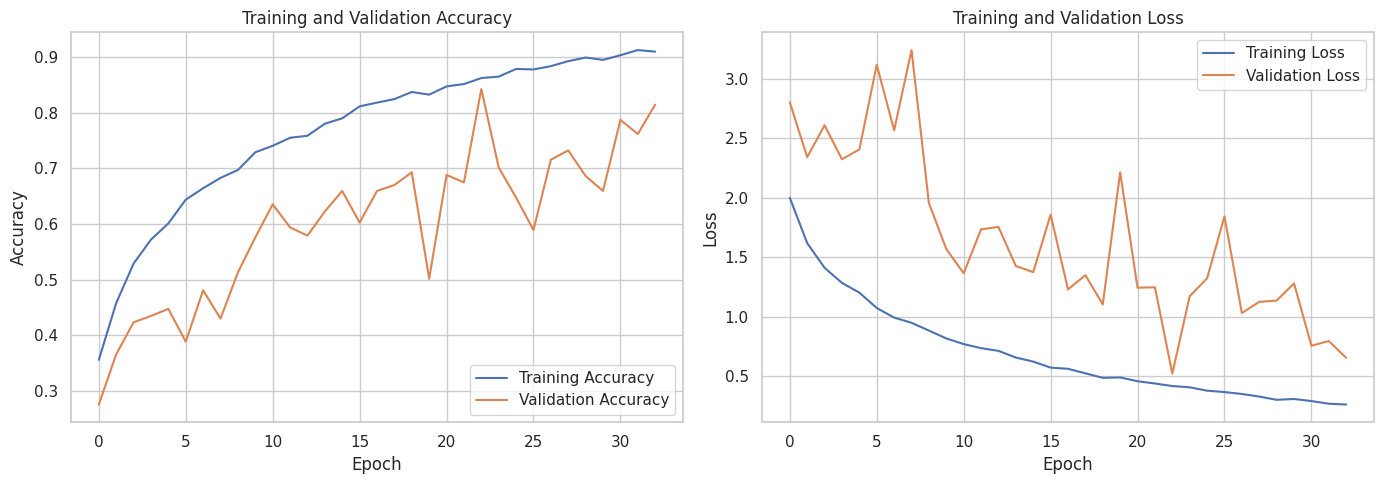


Evaluating model on the Test Set using the best saved weights...

Test Set Evaluation Results:
  Test Loss: 0.5221
  Test Accuracy: 0.8364 (83.64%)


In [17]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K

# --- Focal Loss Definition ---
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)
    return focal_loss_fixed

# --- Data Splitting ---
print("\nSplitting data into Training, Validation, and Test sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_labels, test_size=TEST_SIZE, random_state=42, stratify=y_labels
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=VALIDATION_SIZE / (1 - TEST_SIZE), random_state=42, stratify=y_train
)
print(f"Training set shape: {X_train.shape}, Labels: {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, Labels: {y_val.shape}")
print(f"Test set shape: {X_test.shape}, Labels: {y_test.shape}")

# --- Data Preparation for DenseNet ---
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]
input_shape = X_train.shape[1:]
num_genres = len(genre_mapping)
print(f"Input shape for DenseNet: {input_shape}")

# --- One-Hot Encode Labels ---
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=num_genres)
y_val_one_hot = tf.keras.utils.to_categorical(y_val, num_classes=num_genres)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=num_genres)
print(f"Labels successfully one-hot encoded. Example shape: {y_train_one_hot.shape}")

# --- Build the DenseNet201 Model ---
def build_densenet_model(input_shape, num_classes, learning_rate):
    base_model = DenseNet201(include_top=False, weights='imagenet', input_shape=input_shape)

    # Freeze all layers initially
    base_model.trainable = False

    # Add custom classifier on top
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss=focal_loss(gamma=2.0, alpha=0.25),
                  metrics=['accuracy'])
    model.summary()
    return model

# --- Instantiate and Train the Model ---
model = build_densenet_model(input_shape, num_genres, LEARNING_RATE)

print("\nStarting model training...")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    MODEL_SAVE_PATH, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'
)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, verbose=1, restore_best_weights=True
)

# ReduceLROnPlateau: Reduce learning rate when the validation loss plateaus
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1
)

training_start_time = time.time()
EPOCHS = 100

# Train the model with frozen layers first
history = model.fit(
    X_train, y_train_one_hot,
    validation_data=(X_val, y_val_one_hot),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback],
    verbose=1
)
training_end_time = time.time()
print(f"\nTraining finished in {training_end_time - training_start_time:.2f} seconds.")

# --- Fine-Tuning the Model ---
# Unfreeze the last 50 layers of the model for fine-tuning
print("\nStarting fine-tuning of the last 50 layers...")
for layer in model.layers[-50:]:
    layer.trainable = True

# Recompile the model after unfreezing layers
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss=focal_loss(gamma=2.0, alpha=0.25),
              metrics=['accuracy'])

# Continue training the model with fine-tuning
fine_tuning_start_time = time.time()
history_finetune = model.fit(
    X_train, y_train_one_hot,
    validation_data=(X_val, y_val_one_hot),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback],
    verbose=1
)
fine_tuning_end_time = time.time()
print(f"\nFine-tuning finished in {fine_tuning_end_time - fine_tuning_start_time:.2f} seconds.")

# --- Plot Training History ---
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.tight_layout()
    plt.show()

plot_training_history(history_finetune)

# --- Evaluate on Test Set ---
print("\nEvaluating model on the Test Set using the best saved weights...")
try:
    best_model = tf.keras.models.load_model(MODEL_SAVE_PATH, custom_objects={'focal_loss_fixed': focal_loss(gamma=2.0, alpha=0.25)})
    test_loss, test_accuracy = best_model.evaluate(X_test, y_test_one_hot, verbose=0)
    print(f"\nTest Set Evaluation Results:")
    print(f"  Test Loss: {test_loss:.4f}")
    print(f"  Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
except Exception as e:
    print(f"Error loading or evaluating the best model from {MODEL_SAVE_PATH}: {e}")
    best_model = None


In [18]:
# --- Discussion on Tuning (No Code Execution Here) ---
print("\n--- Hyperparameter Tuning Discussion ---")
print(f"The current model was trained with:")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Epochs (max): {EPOCHS} (Early stopping may have occurred)")
print(f"  Architecture: As defined in build_cnn_model()")
print("\nTo potentially improve performance, further hyperparameter tuning could involve:")
print("  - Adjusting the Learning Rate (e.g., using a learning rate scheduler).")
print("  - Trying different Batch Sizes (e.g., 16, 64, 128).")
print("  - Modifying Dropout rates or adding/removing layers in the CNN.")
print("  - Experimenting with different optimizers (e.g., RMSprop).")
print("  - Using tools like KerasTuner for automated search.")
print("The validation set accuracy/loss curves from the training plot provide guidance for manual tuning.")


--- Hyperparameter Tuning Discussion ---
The current model was trained with:
  Learning Rate: 0.0001
  Batch Size: 32
  Epochs (max): 100 (Early stopping may have occurred)
  Architecture: As defined in build_cnn_model()

To potentially improve performance, further hyperparameter tuning could involve:
  - Adjusting the Learning Rate (e.g., using a learning rate scheduler).
  - Trying different Batch Sizes (e.g., 16, 64, 128).
  - Modifying Dropout rates or adding/removing layers in the CNN.
  - Experimenting with different optimizers (e.g., RMSprop).
  - Using tools like KerasTuner for automated search.
The validation set accuracy/loss curves from the training plot provide guidance for manual tuning.



Generating predictions on the test set...
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step  

Classification Report (Test Set):
              precision    recall  f1-score   support

       blues      0.944     0.907     0.925       150
   classical      0.753     0.993     0.856       150
     country      0.873     0.687     0.769       150
       disco      0.757     0.913     0.828       150
      hiphop      0.840     0.907     0.872       150
        jazz      0.898     0.777     0.833       148
       metal      0.957     0.880     0.917       150
         pop      0.926     0.753     0.831       150
      reggae      0.950     0.753     0.840       150
        rock      0.633     0.793     0.704       150

    accuracy                          0.836      1498
   macro avg      0.853     0.836     0.837      1498
weighted avg      0.853     0.836     0.837      1498


Confusion Matrix (Test Set):


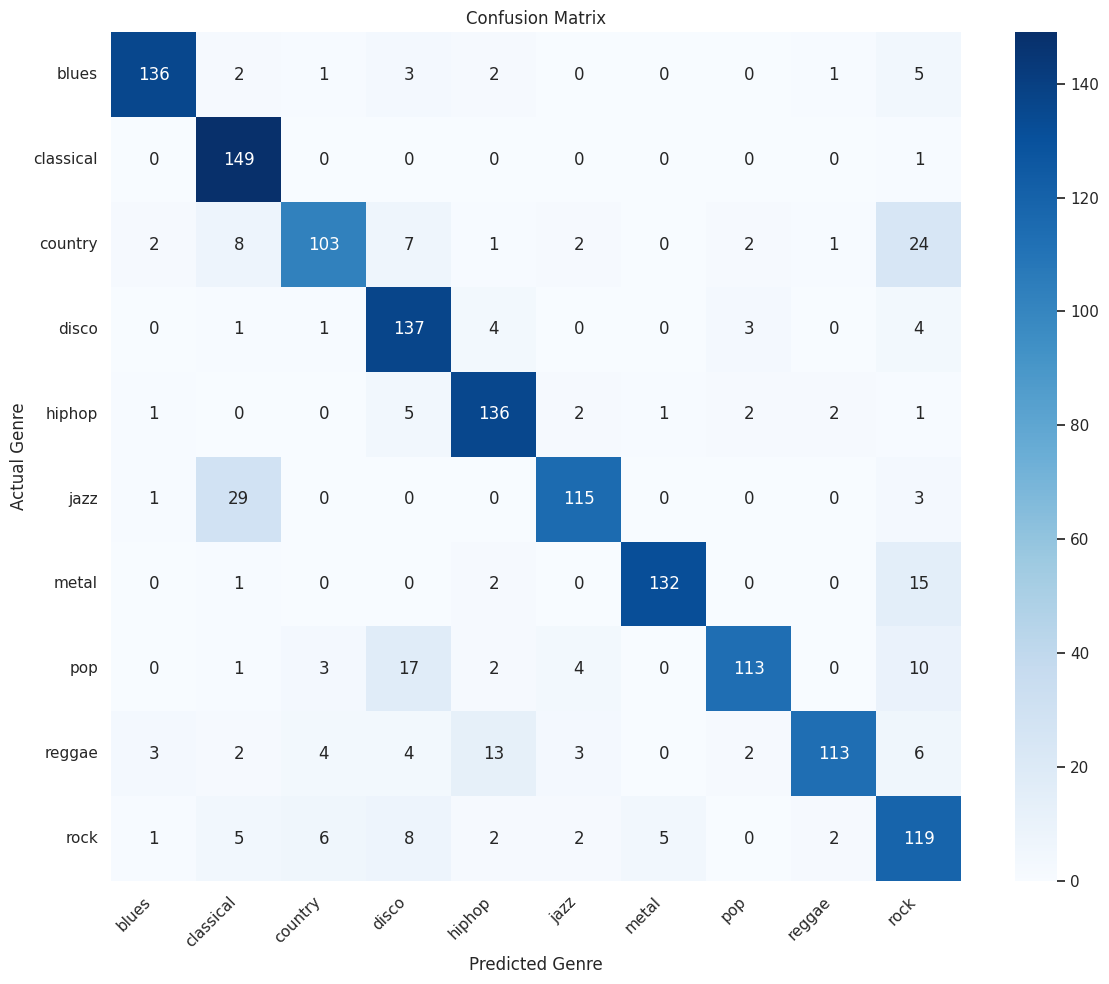


--- Report Summary ---
Overall Test Accuracy: 83.64%

Interpretation:
- The Classification Report shows precision, recall, and F1-score for each genre.
  - High scores indicate good performance for that specific genre.
  - Look for genres with lower scores, indicating areas where the model struggles.
- The Confusion Matrix visualizes these struggles:
  - Numbers on the diagonal represent correct predictions.
  - Off-diagonal numbers show misclassifications (e.g., cell [i, j] shows how many times actual genre 'i' was predicted as genre 'j').
  - Common confusions (large off-diagonal numbers) might suggest acoustically similar genres or areas for model improvement.

Addressing Research Questions (Based on this run):
  - RQ1 (CNN Effectiveness): The achieved accuracy (83.64%) and per-class metrics demonstrate the CNN's capability on this task using Mel-Spectrograms. Performance varies by genre.
  - RQ2 (Augmentation): Augmentation was discussed but not explicitly applied in this training

In [19]:
# --- Generate Predictions on Test Set ---
if best_model:
    print("\nGenerating predictions on the test set...")
    y_pred_probs = best_model.predict(X_test)
    y_pred_labels = np.argmax(y_pred_probs, axis=1) # Get the index of the highest probability

    # --- Classification Report ---
    print("\nClassification Report (Test Set):")
    # Get genre names for the report
    target_names = [genre_mapping.get(i, f"Unknown_{i}") for i in range(num_genres)]
    try:
         report = classification_report(y_test, y_pred_labels, target_names=target_names, digits=3)
         print(report)
    except ValueError as e:
         print(f"Could not generate classification report. Check if all labels are present. Error: {e}")
         print("Unique true labels in y_test:", np.unique(y_test))
         print("Unique predicted labels:", np.unique(y_pred_labels))


    # --- Confusion Matrix ---
    print("\nConfusion Matrix (Test Set):")
    cm = confusion_matrix(y_test, y_pred_labels)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Genre')
    plt.xlabel('Predicted Genre')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

else:
    print("\nSkipping final evaluation metrics as the model was not loaded/trained successfully.")

# --- Final Report Summary (Textual Interpretation) ---
print("\n--- Report Summary ---")
if best_model:
    print(f"Overall Test Accuracy: {test_accuracy*100:.2f}%")
    print("\nInterpretation:")
    print("- The Classification Report shows precision, recall, and F1-score for each genre.")
    print("  - High scores indicate good performance for that specific genre.")
    print("  - Look for genres with lower scores, indicating areas where the model struggles.")
    print("- The Confusion Matrix visualizes these struggles:")
    print("  - Numbers on the diagonal represent correct predictions.")
    print("  - Off-diagonal numbers show misclassifications (e.g., cell [i, j] shows how many times actual genre 'i' was predicted as genre 'j').")
    print("  - Common confusions (large off-diagonal numbers) might suggest acoustically similar genres or areas for model improvement.")
    print("\nAddressing Research Questions (Based on this run):")
    print(f"  - RQ1 (CNN Effectiveness): The achieved accuracy ({test_accuracy*100:.2f}%) and per-class metrics demonstrate the CNN's capability on this task using Mel-Spectrograms. Performance varies by genre.")
    print(f"  - RQ2 (Augmentation): Augmentation was discussed but not explicitly applied in this training run. Comparing runs with/without augmentation would quantify its impact on robustness.")
    print(f"  - RQ3 (Optimization): This run used fixed hyperparameters. Further tuning (as discussed in Step 5) could potentially improve these results.")
    print(f"  - RQ4 (Dataset Challenges): GTZAN is relatively clean and balanced. Challenges observed might include confusions between similar genres (e.g., Rock/Metal, Classical/Jazz nuances). Handling larger, noisier, or imbalanced datasets would require different strategies (more augmentation, class weighting, etc.).")
else:
    print("Model evaluation could not be completed.")

print("\n--- End of Notebook Execution ---")